# Redani: Reddit Animal Counter

This is the code for the reddit post [here](https://www.reddit.com/r/dataisbeautiful/comments/ahxqob/animals_most_mentioned_on_reddit_post_titles_oc/) in [r/dataisbeautiful](https://www.reddit.com/r/dataisbeautiful/)
It counts the number of times the name of an animal is mentioned in reddit post titles.

This is also a good example to get started with the PRAW (Python Reddit API Wrapper) API and PSAW API.

Feel free to send a pull request in case of any errors/suggestions. If you like this, do check out some of my other projects!

## Getting Animal Names

The first step is to get a list of animal names which we can use to search for animal names in submission titles.

The best place to do that is [this](https://en.wikipedia.org/wiki/List_of_animal_names) wikipedia article, which basically has a bunch of common animal names.

To get the values from the table in the above link, we will be using BeautifulSoup4 which is a web scraping tool.

### Step 1: Import the modules we need

In [1]:
from bs4 import BeautifulSoup as bs
import requests
import re

LINK = 'https://en.wikipedia.org/wiki/List_of_animal_names' #Link to the wikipedia page

### Step 2: Get the Page Contents and Extract the Tables

In [2]:
# Using the requests module we can get the page
page = requests.get(LINK)

# Next we parse the page contents using beautifulsoup
soup=bs(page.content, 'html.parser')

# There are two tables in the wikipedia page. So we find both and then select the larger table
tables = soup.find_all('table') # Finding table

# num_rows contain the number of rows in each table
num_rows=[len(table.find('tbody').find_all('tr')) for table in tables]

### Step 3: Extract all the Animal Names from the Largest Table

In [3]:
# We select the table with the maximum number of rows by finding the index of the largest value in num_rows
table=tables[num_rows.index(max(num_rows))]
animal_list=[]

# Finally, for each row in the table, we extract the 'title' field of the first column
for row in table.find('tbody').find_all('tr'):
    if row.find_all('td'):
        animal_list.append(row.find_all('td')[0].find('a').get('title'))

# Let's print the animal list to see which animals we have
print(animal_list)

['Aardvark', 'Albatross', 'Alligator', 'Alpaca', 'Ant', 'Anteater', 'Antelope', 'Ape', 'Armadillo', 'Donkey', 'Baboon', 'Badger', 'Barracuda', 'Bat', 'Bear', 'Beaver', 'Bee', 'Bird', 'Bison', 'Boar', 'African buffalo', 'Butterfly', 'Camel', 'Caribou', 'Cassowary', 'Cat', 'Caterpillar', 'Cattle', 'Chameleon', 'Chamois', 'Cheetah', 'Chicken', 'Chimpanzee', 'Chinchilla', 'Chough', 'Coati', 'Cobra', 'Cockroach', 'Cod', 'Cormorant', 'Coyote', 'Crab', 'Crane (bird)', 'Crocodile', 'Crow', 'Curlew', 'Deer', 'Dinosaur', 'Dog', 'Squalidae', 'Dolphin', 'Donkey', 'Dotterel', 'Dove', 'Dragonfly', 'Duck', 'Dugong', 'Dunlin', 'Eagle', 'Echidna', 'Eel', 'Taurotragus', 'Elephant', 'Elephant seal', 'Elk', 'Emu', 'Falcon', 'Ferret', 'Finch', 'Fish', 'Flamingo', 'Fly', 'Fox', 'Frog', 'Gaur', 'Gazelle', 'Gerbil', 'Giant panda', 'Giraffe', 'Gnat', 'Wildebeest', 'Goat', 'European goldfinch', 'Common merganser', 'Goose', 'Gorilla', 'Goshawk', 'Grasshopper', 'Grouse', 'Guanaco', 'Guinea fowl', 'Guinea pig', 'G

### Step 4: Preprocess the Animal Names

Some of the animal names contain two words and some contain the type of animal like (bird) etc.
We remove both of them as redditors usually will not specify them in their posts.
For example, we usually write buffalo instead of water buffalo

In [4]:
# We use regex to remove any text of the form <(word)> and convert everything to lower case
animal_list=[re.sub(re.compile('\s\(\w+\)'), "", animal).lower() for animal in animal_list]

# If the animal name contains two words, we split the word and only use the second one
# For example 'water buffalo' becomes 'buffalo'
# This creates a problem with the animal 'sand dollar' which we handle later on
animal_list=[animal.split(' ')[1] if ' ' in animal else animal for animal in animal_list]

# We use set to remove any duplicates in our animal list
animal_list=list(set(animal_list))

# 'Sand Dollar' gets converted to 'dollar' which is not an animal, so we remove it from the list
# Sorry Sand Dollar, you just aren't that important to redditors!
animal_list.remove('dollar')

# Now animal list looks like
print(animal_list)

['gerbil', 'caterpillar', 'dugong', 'barracuda', 'hamster', 'hyena', 'rat', 'mongoose', 'rhinoceros', 'squirrel', 'weasel', 'shark', 'raven', 'dunlin', 'kouprey', 'jay', 'fish', 'cat', 'newt', 'fly', 'eagle', 'wasp', 'mosquito', 'aardvark', 'vicuña', 'emu', 'ape', 'elephant', 'echidna', 'yak', 'seahorse', 'stegosaurus', 'lion', 'turtle', 'cheetah', 'hornet', 'okapi', 'gull', 'moose', 'sloth', 'baboon', 'turkey', 'pug', 'parrot', 'armadillo', 'partridge', 'wolverine', 'panther', 'herring', 'wolf', 'hedgehog', 'tarsier', 'grouse', 'chough', 'frog', 'snake', 'cattle', 'tiger', 'cassowary', 'salamander', 'curlew', 'coati', 'gazelle', 'guanaco', 'mink', 'pinniped', 'kangaroo', 'deer', 'coyote', 'hawk', 'bear', 'loris', 'narwhal', 'rabbit', 'antelope', 'crow', 'seal', 'fox', 'buffalo', 'horse', 'sheep', 'sandpiper', 'raccoon', 'impala', 'dog', 'jaguar', 'termite', 'anteater', 'shrew', 'taurotragus', 'oyster', 'duck', 'giraffe', 'finch', 'rook', 'falcon', 'spider', 'koala', 'lyrebird', 'swan'

### Step 5: We can now use the PRAW and PSAW to get reddit posts

The reason for not using PRAW completely is because it is not possible to get more than 1000 posts at a time. Further, you cannot get posts by a particular date.

To solve this issue we use the pushshift api.

First, we import all the modules

In [5]:
import praw
from psaw import PushshiftAPI
import datetime as dt
from tqdm import tqdm

### Step 6: Create a PRAW and PSAW object

I have left the `client_id`, `client_secret`, `user_agent` fields blank.
You can get your own client_id's and all from the reddit developer page

In [6]:
# Create a praw object
reddit=praw.Reddit(client_id='your id', client_secret='your secret', user_agent='your agent')

# Use the praw object to create a psaw object
api = PushshiftAPI(reddit)

# Check to see if it is working
print(reddit.read_only)

True


### Step 7: Get Submissions from a particular date range

In [7]:
# Using the datetime module we can get the unix timestamps
start_epoch=int(dt.datetime(2018, 1, 1).timestamp())
end_epoch=int(dt.datetime(2019, 1, 1).timestamp())

# This will create a generator that you can query for all posts within a particular date
submissions=api.search_submissions(after=start_epoch, before=end_epoch)

### Step 8: Lets get all the posts and save them to a text file

Since there can be a lot of posts, you might run out of memory.
So create a `data.txt` where we can write our posts.

In [8]:
import time

count=0
title_cache=[]

# Using time we can check how long it takes to get posts
start_time=time.time()

for sub in submissions:
    
    #We keep track of a counter to count how many posts have been received
    count=count+1
    
    # Appending the title to a list
    title_cache.append(sub.title.lower())
    
    # Instead of saving posts one at a time,
    # We save it every 500 posts
    if count%500==0:
        with open('data.txt', 'w') as f:
            for title in title_cache:
                f.write(f"{title}\n") # Write each title to a new line
        print(f"Total : {count}")

        # Print the time when the last submission was posted
        # You can use this to estimate how long it might take to get posts
        print(sub.created)
        
        #Print time elapsed
        print(f"Time: {time.time()-start_time}")
        start_time=time.time()
        print('_______________')
        
        # Remove the next line to keep it running indefinitely
        break

Total : 500
1546309727.0
Time: 21.25840401649475
_______________


### Step 9: Count the Occurences of each Animal

We create a dictionary of `animal_name`:`count`

To do this, we open the text file and search for the count of the words `" <animal> "` and `" <animal>s "`

Note: We cannot just search for the animal as it will also take into account substrings like
for example `'ant' in 'cant'` will result in `True`

In [13]:
animal_dict={}

# Open the file as f
with open('data.txt', 'r') as f:
    lines=f.read()
    for animal in animal_list:
        
        # Count the occurences of the animal in the file
        animal_dict[animal]=lines.count(" "+animal+" ")+lines.count(" "+animal+"s ")

# Here we sort it to get the top 20 mentioned animals
# This returns a list of tuples of the form [(animal1, count1), (animal2, count2)]
animals_sorted=sorted(animal_dict.items(), key=lambda kv: kv[1], reverse=True)[:20]

# Finally, we seperate the keys (animals) and values (count) into two lists for wasy plotting
count=[]
animals=[]
for animal in animals_sorted:
    animals.append(animal[0])
    count.append(animal[1])

### Step 10: Plotting the graph

We use matplotlib to plot the graph. So we need to import it

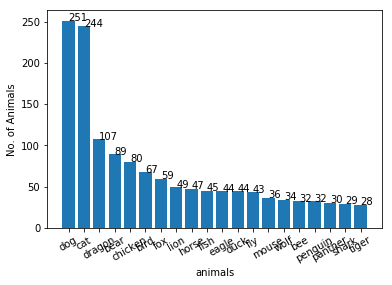

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

index = np.arange(len(count))
bar_width=0.5
plt.bar(index, count)
plt.xlabel("animals")
plt.ylabel('No. of Animals')
plt.xticks(index, animals, rotation=30)
for a, b in zip(index, count):
    plt.text(a, b, str(b))
plt.show()